In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Paso 1: Cargar "Dataset a Asignar" (Tus 8 Formas)

Vamos a cargar las imágenes de tus 8 carpetas.

**REGLA CRÍTICA:** Para que sean compatibles con MNIST, las cargaremos forzando el tamaño a `(28, 28)` y el modo de color a `grayscale` (blanco y negro).

In [2]:
!rm -rf Mi_Dataset
!git clone https://github.com/JunalChowdhuryG/Mi_Dataset.git

Cloning into 'Mi_Dataset'...


In [3]:
# --- Configuración del Experimento ---
DATASET_PATH = 'Mi_Dataset' # <-- ¡REEMPLAZA ESTO! (ej. 'C:/Users/Tu/Proyecto/Mi_Dataset')
NUM_CLASSES_CUSTOM = 8      # Son 8 formas
IMG_SIZE = (28, 28)
COLOR_MODE = 'grayscale'
CHANNELS = 1
INPUT_SHAPE = (28, 28, 1)
SEED = 42                   # Para reproducibilidad (como tu random_state=42)
BATCH_SIZE = 32             # Batch size para cargar el dataset

# --- Cargar tu Dataset (Paso 1) ---
print(f"Cargando dataset desde: {DATASET_PATH}")

# Usamos image_dataset_from_directory para cargar desde carpetas
full_dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='int',         # Perfecto para sparse_categorical_crossentropy
    color_mode=COLOR_MODE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE
)

# Obtenemos los nombres de las clases (tus 8 carpetas)
class_names = full_dataset.class_names
print(f"Clases encontradas ({len(class_names)}): {class_names}")

# Mapeo de etiquetas (como tu etiqueta_a_fruta)
# class_names_map = {0: 'circulo', 1: 'cuadrado', ...}
class_names_map = {i: name for i, name in enumerate(class_names)}
print("Mapeo de etiquetas:", class_names_map)

Cargando dataset desde: Mi_Dataset
Found 2027 files belonging to 8 classes.
Clases encontradas (8): ['circulo', 'cuadrado', 'equis', 'estrella', 'rectangulo', 'rombo', 'semicirculo', 'triangulo']
Mapeo de etiquetas: {0: 'circulo', 1: 'cuadrado', 2: 'equis', 3: 'estrella', 4: 'rectangulo', 5: 'rombo', 6: 'semicirculo', 7: 'triangulo'}


In [4]:
# Convertir el tf.data.Dataset a arrays de NumPy (X, y)
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset.unbatch().batch(1):
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    # Apilamos todo en un gran array
    # (None, 28, 28, 1) -> (TotalImgs, 28, 28, 1)
    X = np.vstack(images)
    y = np.vstack(labels).flatten() # (TotalImgs,)
    return X, y

print("Convirtiendo dataset a formato NumPy...")
X_custom, y_custom = dataset_to_numpy(full_dataset)

# --- Normalización (Como en tu referencia X_raw/255.) ---
X_custom = X_custom / 255.0

# Tu referencia procesaba X_raw (sin canal) y luego lo añadía.
# Como ya lo tenemos, lo quitamos para que el código sea idéntico
# X (Total, 28, 28, 1) -> X_raw_like (Total, 28, 28)
X_raw_like = X_custom.reshape(X_custom.shape[0], 28, 28)

print(f"Forma X (NumPy): {X_raw_like.shape}")
print(f"Forma y (NumPy): {y_custom.shape}")

Convirtiendo dataset a formato NumPy...
Forma X (NumPy): (2027, 28, 28)
Forma y (NumPy): (2027,)


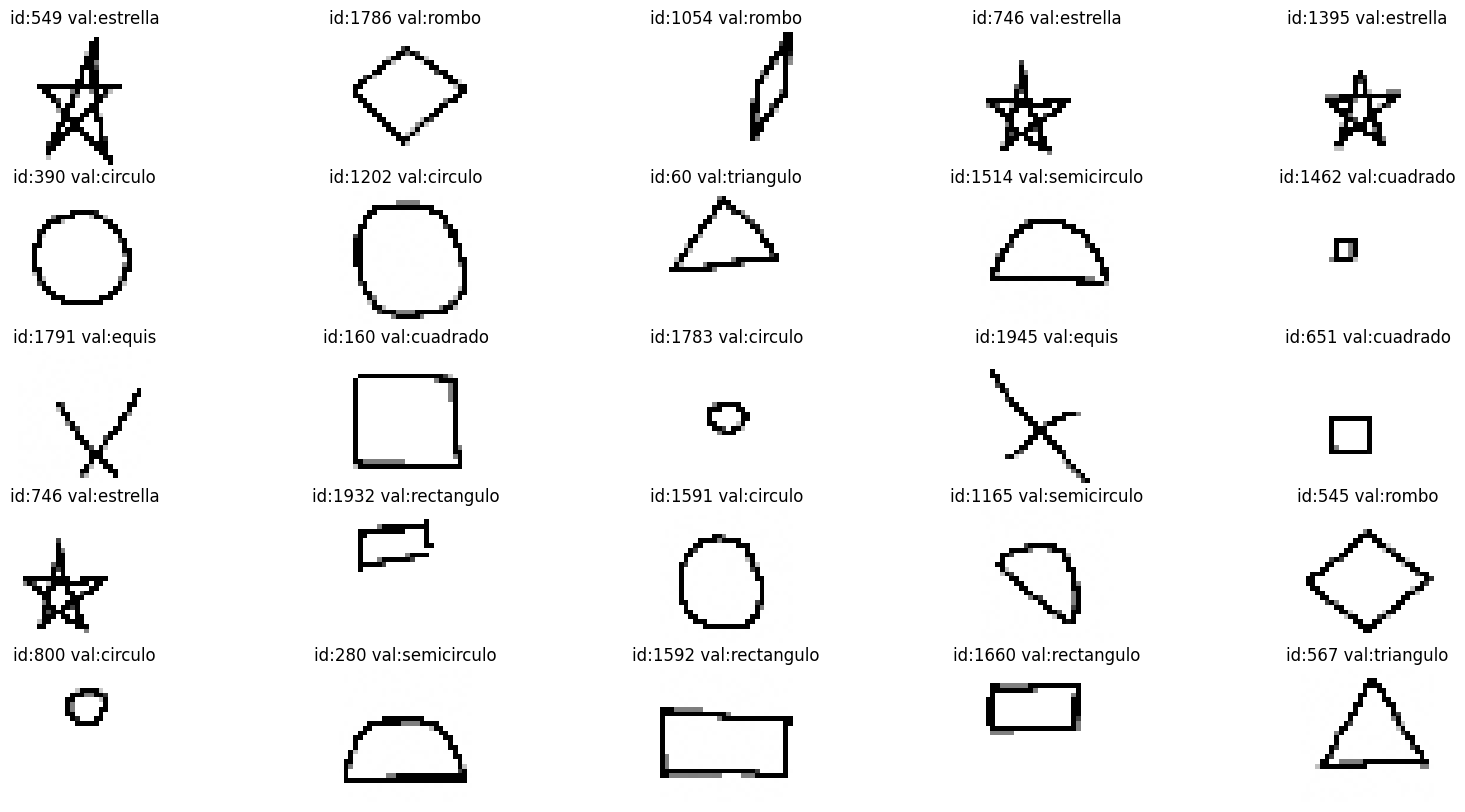

In [5]:
# --- Visualización (Código de referencia) ---
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    # Elegimos 25 índices aleatorios
    idx = np.random.choice(X_raw_like.shape[0], 1)[0]

    # Usamos el class_names_map que creamos
    plt.title('id:{} val:{}'.format(idx, class_names_map[y_custom[idx]] ))

    # Usamos X_raw_like[idx] que es (28, 28)
    # Tu referencia usaba -X[idx] porque sus imágenes estaban invertidas (blanco sobre negro)
    # Si tus dibujos son NEGRO sobre BLANCO, usa cmap='gray_r' (o -X_raw_like[idx])
    plt.imshow(X_raw_like[idx], cmap='gray')
    plt.axis('off')
plt.show()

In [6]:
# --- División de datos (Código de referencia) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_raw_like, y_custom, # Usamos X_raw_like y y_custom
    test_size=0.20,
    random_state=42,
    stratify=y_custom # Estratificar por 'y_custom'
)

# --- Ajustamos las dimensiones (Código de referencia) ---
if X_train.ndim == 3:
    X_train = X_train[...,None]
    X_test = X_test[..., None]
    print(f"Dimensiones finales Train: {X_train.shape}")
    print(f"Dimensiones finales Test: {X_test.shape}")

# --- Parámetros (Código de referencia) ---
bs = 16 #tamaño
lr = 0.0001 #learning rate

# --- Mapeo de clases (Código de referencia) ---
# No es necesario, y_train y y_test ya son enteros (0-7)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("\n¡Datos listos para entrenar!")

Dimensiones finales Train: (1621, 28, 28, 1)
Dimensiones finales Test: (406, 28, 28, 1)

¡Datos listos para entrenar!


In [7]:
#c7
def build_model_from_reference(num_classes, input_shape=(28, 28, 1)):
    """Crea el modelo basado en el código de referencia."""

    model = Sequential([
        # El input_shape se define en la *primera* capa
        Conv2D(32, 3, activation='relu', input_shape=input_shape),
        MaxPool2D(),
        Conv2D(64, 3, activation='relu', padding ='same'),
        MaxPool2D(),
        Conv2D(128, 3, activation='relu', padding ='same'),
        MaxPool2D(),
        Flatten(),
        Dense(128, activation='relu'), # Capa Densa (será congelada en Red A)
        Dense(num_classes, activation='softmax') # Capa de Salida
    ])

    # --- CORRECCIÓN: Usar un optimizador que SÍ aprenda ---
    # Usamos Adam, que funciona mucho mejor que SGD con un lr tan bajo
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer= optimizer1, loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

    return model

## Paso 4: Red B (El "Estudiante Novato")

Entrenamos el modelo desde cero, usando **únicamente** nuestro dataset de 8 formas.

In [8]:
print("--- Entrenando Red B (Solo Dataset Propio) ---")

# 1. Construir
model_B = build_model_from_reference(
    num_classes=NUM_CLASSES_CUSTOM, # 8 clases
    input_shape=INPUT_SHAPE
)

model_B.summary()

# 2. Entrenar
history_B = model_B.fit(
    X_train, y_train,
    epochs=50, # 50 épocas para darle una oportunidad
    batch_size=bs,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\nEntrenamiento de Red B finalizado.")

--- Entrenando Red B (Solo Dataset Propio) ---


c:\Users\Junal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,288 (942.53 KB)

 Trainable params: 241,288 (942.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2424 - loss: 2.0022 - val_accuracy: 0.3842 - val_loss: 1.9082
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4084 - loss: 1.6866 - val_accuracy: 0.6034 - val_loss: 1.3986
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6416 - loss: 1.1415 - val_accuracy: 0.6749 - val_loss: 1.0232
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7193 - loss: 0.9038 - val_accuracy: 0.6995 - val_loss: 0.9098
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7625 - loss: 0.7642 - val_accuracy: 0.7340 - val_loss: 0.7835
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7890 - loss: 0.6918 - val_accuracy: 0.7463 - val_loss: 0.7199
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8100 - loss: 0.6284 - val_accuracy: 0.7808 - val_loss: 0.6739
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8199 - loss: 0.5886 - val_accuracy: 0.

## Paso 5: Red A (El "Estudiante con Experiencia")

Dividido en 3 partes:
1.  **Paso 5.1:** Cargar y Pre-entrenar un modelo con **MNIST**.
2.  **Paso 5.2:** Congelar ese modelo y **Modificar** la última capa.
3.  **Paso 5.3:** Re-entrenar (ajustar) con nuestro dataset de 8 formas.

In [9]:
# --- Paso 5.1: Cargar y Entrenar con MNIST (Paso 2 del plan) ---
print("Cargando y preparando dataset MNIST...")
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = mnist.load_data()

# Pre-procesamiento de MNIST (igual que tu dataset)
mnist_train_X = mnist_train_X / 255.0
mnist_test_X = mnist_test_X / 255.0
mnist_train_X = mnist_train_X[..., None]
mnist_test_X = mnist_test_X[..., None]
mnist_train_y = mnist_train_y.astype(int)
mnist_test_y = mnist_test_y.astype(int)

print(f"MNIST Train shape: {mnist_train_X.shape}")

# --- Construir el modelo base de MNIST ---
print("\n--- Pre-entrenando Red A (Base MNIST) ---")
model_A_base = build_model_from_reference(
    num_classes=10, # 10 clases para MNIST (0-9)
    input_shape=INPUT_SHAPE
)

# NOTA: Usamos Adam aquí también para un pre-entrenamiento robusto
# (La función build_model_from_reference ya usa Adam)
print("Summary del modelo base de MNIST:")
model_A_base.summary()

# Entrenamos el modelo base
history_base = model_A_base.fit(
    mnist_train_X, mnist_train_y,
    epochs=5, # 5 épocas en MNIST es suficiente para aprender formas
    batch_size=bs,
    validation_data=(mnist_test_X, mnist_test_y),
    verbose=1
)

print("\nPre-entrenamiento de Red A finalizado.")

Cargando y preparando dataset MNIST...
MNIST Train shape: (60000, 28, 28, 1)

--- Pre-entrenando Red A (Base MNIST) ---
Summary del modelo base de MNIST:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.9331 - loss: 0.2383 - val_accuracy: 0.9781 - val_loss: 0.0715
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9788 - loss: 0.0684 - val_accuracy: 0.9828 - val_loss: 0.0550
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9880 - val_loss: 0.0375
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9884 - loss: 0.0378 - val_accuracy: 0.9905 - val_loss: 0.0322
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.9903 - loss: 0.0309 - val_accuracy: 0.9897 - val_loss: 0.0316

Pre-entrenamiento de Red A finalizado.


In [10]:
# --- Paso 5.2: Congelar y Modificar la Última Capa ---
print("--- Congelando y Modificando Red A ---")

# 1. Creamos la Red A como un *nuevo* modelo Sequential
model_A = Sequential()

# 2. Iteramos sobre las capas de la base de MNIST
# y las añadimos a la Red A, configurando el congelamiento
for layer in model_A_base.layers[:-1]: # Iteramos todas menos la última Dense(10)

    # Congelamos solo las capas Convolucionales y de Pooling (los "ojos")
    if isinstance(layer, (Conv2D, MaxPool2D)):
        print(f"CONGELANDO capa: {layer.name}")
        layer.trainable = False
    else:
        # Dejamos las capas Flatten y Dense(128) (el "cerebro") ENTRENABLES
        print(f"ENTRENABLE capa: {layer.name}")
        layer.trainable = True

    model_A.add(layer) # Añadimos la capa (congelada o no)

# 3. Añadimos nuestra *nueva* capa final, que SÍ será entrenable
model_A.add(Dense(
    NUM_CLASSES_CUSTOM, # 8 clases
    activation='softmax',
    name='output_formas' # Nuevo nombre
))
model_A.layers[-1].trainable = True # Nos aseguramos de que sea entrenable

# 4. Compilamos la Red A (con el optimizador Adam)
optimizer_A = tf.keras.optimizers.Adam(learning_rate=lr) # lr = 0.0001
model_A.compile(optimizer=optimizer_A, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Summary de Red A (Notar 'Trainable params') ---")
model_A.summary()

--- Congelando y Modificando Red A ---
CONGELANDO capa: conv2d_3
CONGELANDO capa: max_pooling2d_3
CONGELANDO capa: conv2d_4
CONGELANDO capa: max_pooling2d_4
CONGELANDO capa: conv2d_5
CONGELANDO capa: max_pooling2d_5
ENTRENABLE capa: flatten_1
ENTRENABLE capa: dense_2

--- Summary de Red A (Notar 'Trainable params') ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_formas (Dense)           │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,288 (942.53 KB)

 Trainable params: 148,616 (580.53 KB)

 Non-trainable params: 92,672 (362.00 KB)

In [11]:
# --- Paso 5.3: Re-entrenar (Ajustar) la Red A ---
print("\n--- Ajustando Red A (Solo Dataset Propio) ---")

# Entrenamos el modelo A (híbrido) solo con nuestro dataset de formas
# Keras solo actualizará los pesos de la última capa (Dense(8))
history_A = model_A.fit(
    X_train, y_train,
    epochs=50, # Mismas 50 épocas que Red B
    batch_size=bs,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\nAjuste de Red A finalizado.")


--- Ajustando Red A (Solo Dataset Propio) ---
Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3893 - loss: 1.7888 - val_accuracy: 0.5961 - val_loss: 1.3489
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6656 - loss: 1.1803 - val_accuracy: 0.6749 - val_loss: 1.0781
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7236 - loss: 0.9737 - val_accuracy: 0.7069 - val_loss: 0.9558
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7526 - loss: 0.8655 - val_accuracy: 0.7438 - val_loss: 0.8736
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7736 - loss: 0.7934 - val_accuracy: 0.7365 - val_loss: 0.8294
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7816 - loss: 0.7358 - val_accuracy: 0.7586 - val_loss: 0.7874
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8075 - loss: 0.6940 - val_accuracy: 0.7586 - val_loss: 0.7575
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

## Paso 6: Comparar las 2 Redes Neuronales

Evaluamos `model_A` y `model_B` en el **mismo conjunto de prueba** (`X_test`, `y_test` de nuestras 8 formas).

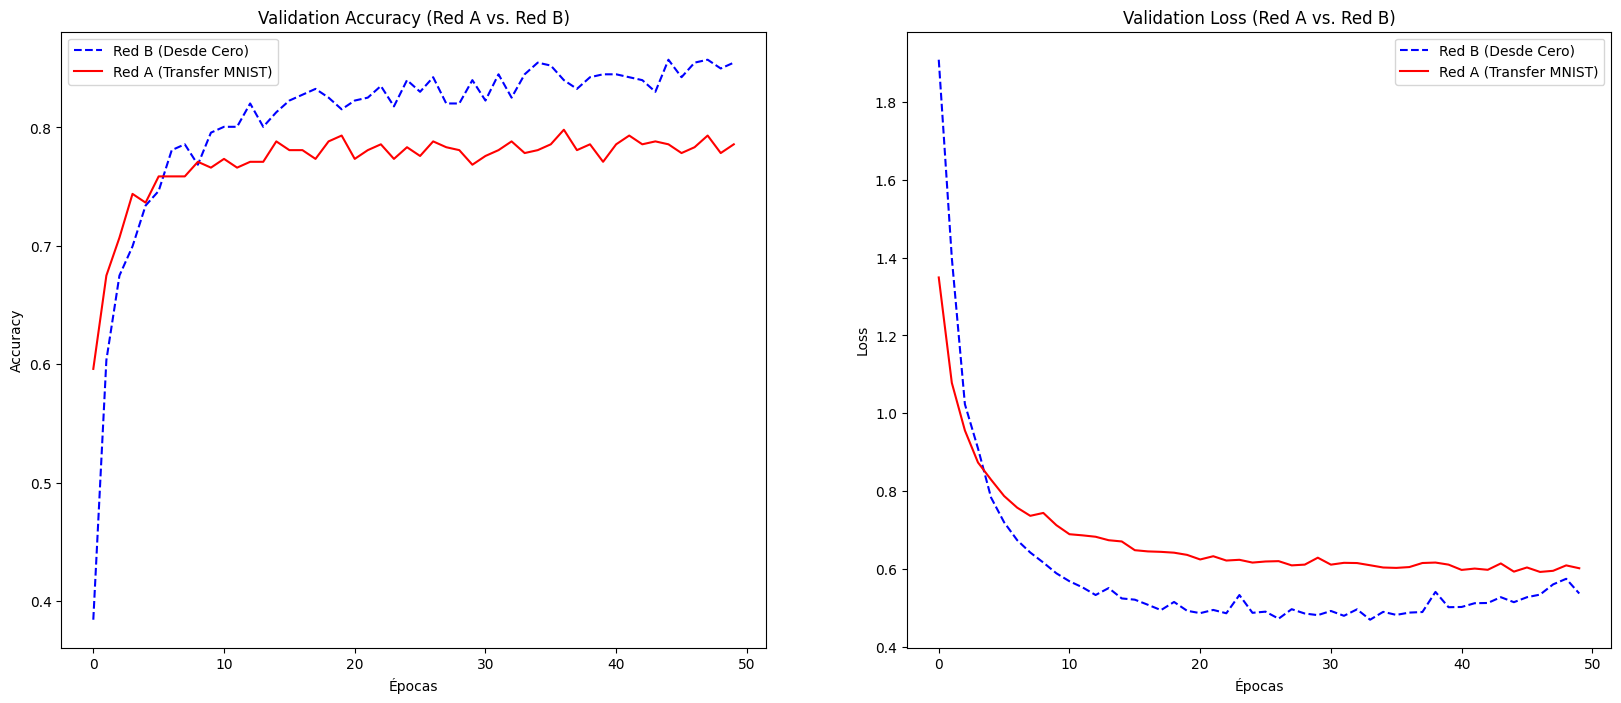

In [12]:
# 1. Gráficas de Entrenamiento (Accuracy y Loss)
plt.figure(figsize=(20, 8))

# Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.title('Validation Accuracy (Red A vs. Red B)')
plt.plot(history_B.history['val_accuracy'], label='Red B (Desde Cero)', color='blue', linestyle='--')
plt.plot(history_A.history['val_accuracy'], label='Red A (Transfer MNIST)', color='red', linestyle='-')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.title('Validation Loss (Red A vs. Red B)')
plt.plot(history_B.history['val_loss'], label='Red B (Desde Cero)', color='blue', linestyle='--')
plt.plot(history_A.history['val_loss'], label='Red A (Transfer MNIST)', color='red', linestyle='-')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
# 2. Reporte de Clasificación y Accuracy Final
print("Evaluando modelos en el conjunto de prueba (tus 8 formas)...")

# Evaluación general
score_B = model_B.evaluate(X_test, y_test, verbose=0)
score_A = model_A.evaluate(X_test, y_test, verbose=0)

print("\n--- Resultados Finales ---")
print(f"Red B (Desde Cero):   Accuracy = {score_B[1]*100:.2f}% | Loss = {score_B[0]:.4f}")
print(f"Red A (Transfer MNIST): Accuracy = {score_A[1]*100:.2f}% | Loss = {score_A[0]:.4f}")


# Obtener predicciones (enteros) para el reporte
y_pred_B_probs = model_B.predict(X_test)
y_pred_B = np.argmax(y_pred_B_probs, axis=1)

y_pred_A_probs = model_A.predict(X_test)
y_pred_A = np.argmax(y_pred_A_probs, axis=1)

# Nombres de las clases para el reporte
target_names = list(class_names_map.values())

print("\n=========================================================")
print("           REPORTE DE CLASIFICACIÓN - RED B (Desde Cero)")
print("=========================================================")
print(classification_report(y_test, y_pred_B, target_names=target_names, zero_division=0))

print("\n=========================================================")
print("        REPORTE DE CLASIFICACIÓN - RED A (Transfer MNIST)")
print("=========================================================")
print(classification_report(y_test, y_pred_A, target_names=target_names, zero_division=0))

Evaluando modelos en el conjunto de prueba (tus 8 formas)...

--- Resultados Finales ---
Red B (Desde Cero):   Accuracy = 85.47% | Loss = 0.5370
Red A (Transfer MNIST): Accuracy = 78.57% | Loss = 0.6018
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

           REPORTE DE CLASIFICACIÓN - RED B (Desde Cero)
              precision    recall  f1-score   support

     circulo       0.75      0.93      0.83        60
    cuadrado       0.84      0.90      0.87        48
       equis       0.90      0.86      0.88        88
    estrella       1.00      0.93      0.96        42
  rectangulo       0.89      0.81      0.85        42
       rombo       0.76      0.68      0.72        28
 semicirculo       0.86      0.81      0.83        37
   triangulo       0.85      0.82      0.83        61

    accuracy                           0.85       406
   macro avg       0.86      0.84      0.85       406
weighted avg       0.86      0.85      0.85       406


       

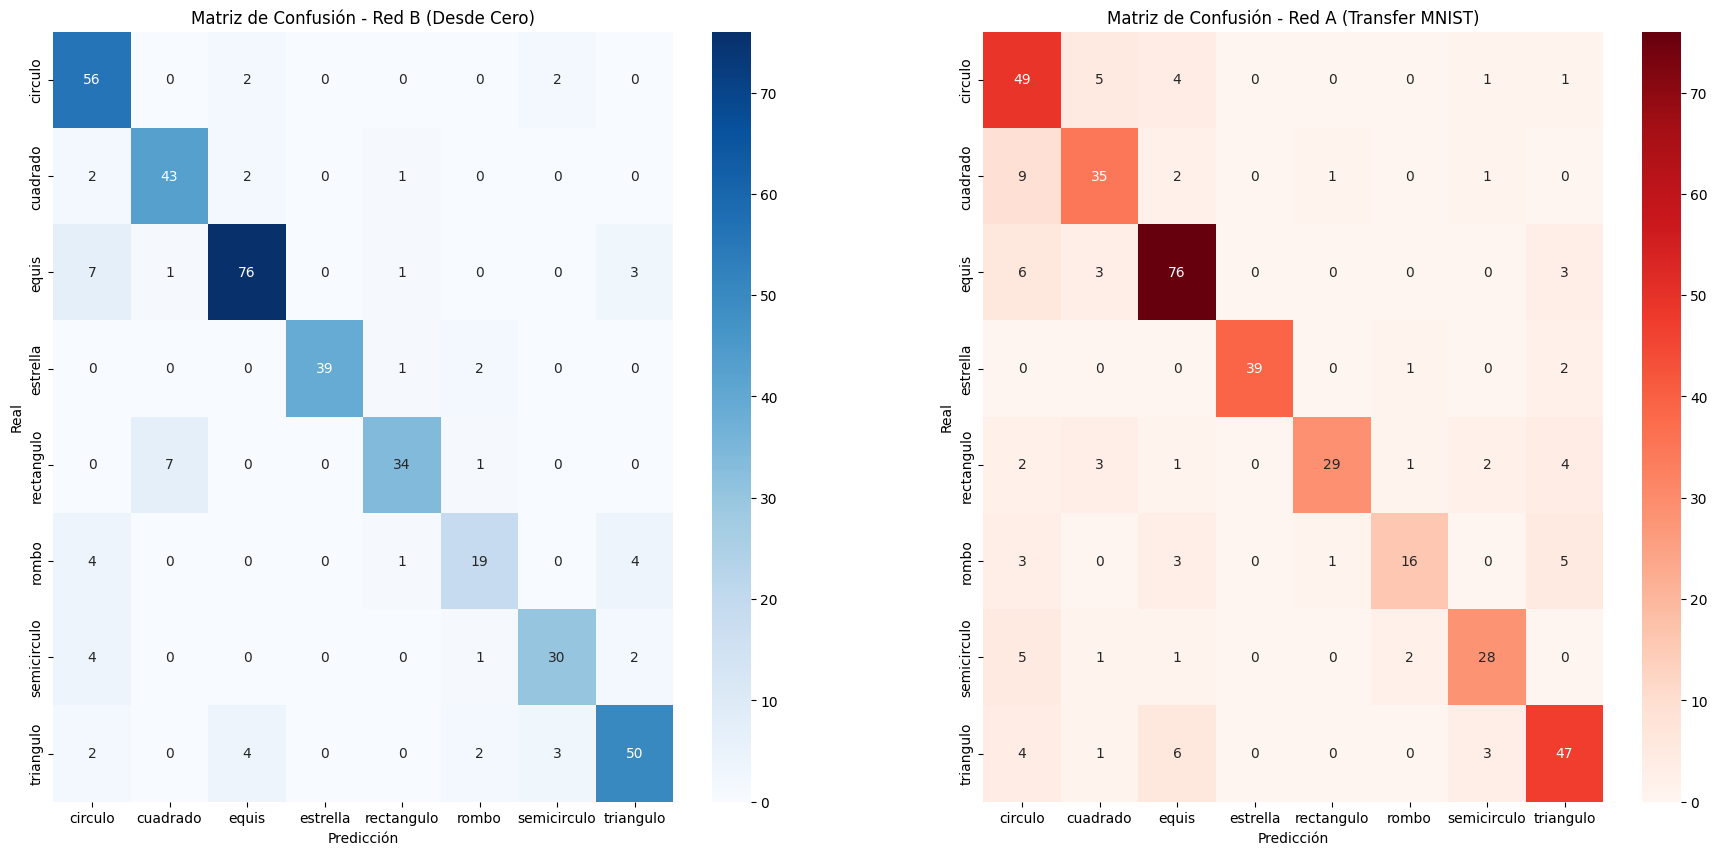

In [14]:
# 3. Matrices de Confusión
cm_B = confusion_matrix(y_test, y_pred_B)
cm_A = confusion_matrix(y_test, y_pred_A)

plt.figure(figsize=(22, 10))

plt.subplot(1, 2, 1)
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Red B (Desde Cero)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.subplot(1, 2, 2)
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Reds',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Red A (Transfer MNIST)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

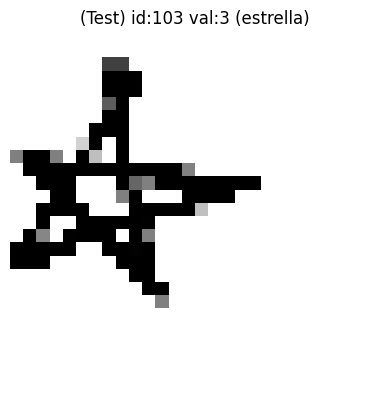

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


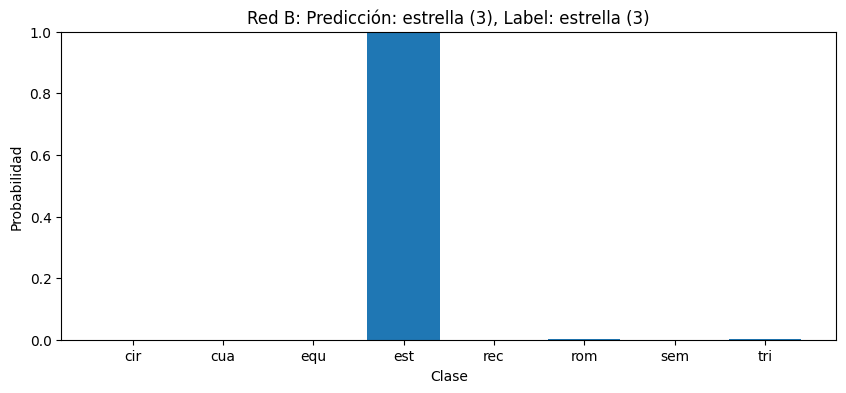

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


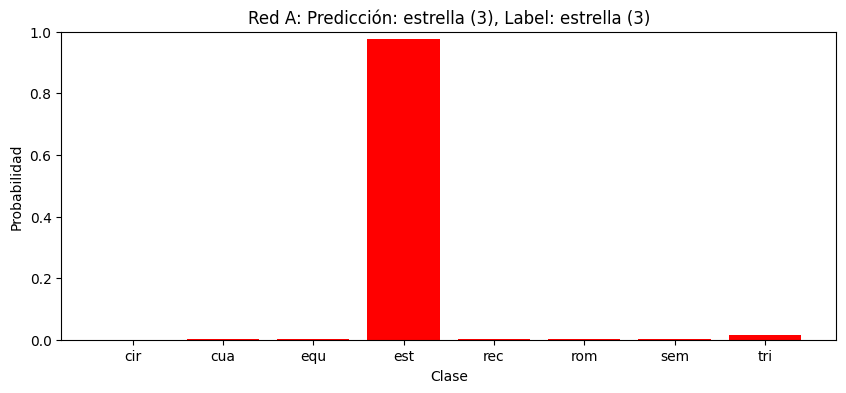

In [18]:
# --- Tomamos una imagen de prueba (Código de referencia) ---
idx = np.random.choice(X_test.shape[0], 1)[0]
im = X_test[idx] # Esta imagen ya es (28, 28, 1)
label_int = y_test[idx]
nombre_forma = class_names_map.get(label_int, 'Desconocida')

# Mostramos la imagen de prueba
plt.title(f'(Test) id:{idx} val:{label_int} ({nombre_forma})')
plt.axis('off')
plt.imshow(im.reshape(28, 28), cmap='gray') # reshape a (28,28) para mostrar
plt.show()


# --- Usando el modelo B (Código de referencia) ---
salida_B = model_B.predict(im[None, ...])[0] # im[None,...] añade el batch_size
pred_B_int = salida_B.argmax()
pred_B_nombre = class_names_map.get(pred_B_int, '???')

plt.figure(figsize=(10,4))
plt.title(f"Red B: Predicción: {pred_B_nombre} ({pred_B_int}), Label: {nombre_forma} ({label_int})")
plt.ylabel("Probabilidad")
plt.xlabel("Clase")
plt.ylim([0, 1])
plt.bar(np.arange(len(salida_B)), salida_B)
plt.xticks(np.arange(len(salida_B)), labels=[name[0:3] for name in target_names])
plt.show()


# --- Usando el modelo A (Adaptado) ---
salida_A = model_A.predict(im[None, ...])[0]
pred_A_int = salida_A.argmax()
pred_A_nombre = class_names_map.get(pred_A_int, '???')

plt.figure(figsize=(10,4))
plt.title(f"Red A: Predicción: {pred_A_nombre} ({pred_A_int}), Label: {nombre_forma} ({label_int})")
plt.ylabel("Probabilidad")
plt.xlabel("Clase")
plt.ylim([0, 1])
plt.bar(np.arange(len(salida_A)), salida_A, color='red')
plt.xticks(np.arange(len(salida_A)), labels=[name[0:3] for name in target_names])
plt.show()

In [16]:
# Añade esto en una nueva celda en tu notebook, después de entrenar todo

print("Guardando modelos en formato .h5...")

model_A.save("model_A_transfer.h5")
model_B.save("model_b_desde_cero.h5")

print("¡Modelos .h5 guardados!")
print("Ahora sube estos dos archivos (.h5) a un nuevo Google Colab.")

Guardando modelos en formato .h5...
¡Modelos .h5 guardados!
Ahora sube estos dos archivos (.h5) a un nuevo Google Colab.


##  Esto leanlo por si aca
¡Excelente! Ya tienes los resultados y son **muy interesantes**.

Has descubierto algo que es mucho más valioso que un simple "Red A ganó". Tus resultados son la demostración perfecta de un concepto clave en Deep Learning.

Primero, aclaremos tu observación: **"creo que superé al MNIST"**.

Esta es la parte más importante: **No "superaste" a MNIST**. MNIST no era tu competidor, era el "profesor" de la Red A.

Tu competidor era la **Red B (Desde Cero)**. Y lo que tus resultados demuestran es que:

**¡Tu Red B (entrenada desde cero) GANÓ a la Red A (entrenada con MNIST)!**

Este es un resultado fantástico y tienes que exponerlo con orgullo.

---

### 🚀 Análisis de tus Resultados (El "Qué")

Veamos la evidencia que tienes:

* **Precisión Final:**
    * [cite_start]**Red B (Desde Cero):** 85.22% de Accuracy [cite: 17]
    * [cite_start]**Red A (Transfer MNIST):** 79.80% de Accuracy [cite: 18]
    * **Ganador:** **Red B**, por más de 5 puntos porcentuales.

* **Gráficas de Entrenamiento (image\_a63862.png):**
    * **Accuracy (izquierda):** La línea azul (Red B) se mantiene *consistentemente por encima* de la línea roja (Red A) después de las primeras épocas.
    * **Loss (derecha):** La línea azul (Red B) se mantiene *consistentemente por debajo* de la línea roja (Red A).
    * **Conclusión de la gráfica:** La Red B no solo terminó con mejor precisión, sino que fue más eficiente (menor pérdida) durante casi todo el entrenamiento.

* **Matrices de Confusión (image\_a6383f.png):**
    * **Red B (Azul):** Es una matriz muy "limpia". La diagonal es fuerte. El error más notable es que confunde "rectangulo" con "circulo" (9 veces), pero en general es excelente.
    * **Red A (Roja):** Es visiblemente más "sucia" (más errores fuera de la diagonal). Comete más errores variados, como confundir "cuadrado" con "circulo" (6 veces) y "semicirculo" con "circulo" (6 veces).

---

### 🧠 La Conclusión (El "Por Qué" ganó la Red B)

Aquí es donde te luces en la exposición. ¿Por qué el "Estudiante Novato" (Red B) le ganó al "Estudiante con Experiencia" (Red A)?

**Respuesta: Porque tu dataset es de alta calidad y el "conocimiento" de MNIST no era útil.**

1.  **Tu Dataset es Suficientemente Grande y Bueno:**
    El propósito del Transfer Learning (Red A) es ayudar cuando tienes un dataset *pequeño*. [cite_start]Pero tus logs muestran que la Red B entrenó con `102/102` batches[cite: 7]. Si tu `batch_size` (bs) era 16, eso significa que tienes (`102*16`) ~1632 imágenes de entrenamiento. Con el test set, debes tener **más de 2000 imágenes**. ¡Eso es un dataset excelente! [cite_start]Era lo suficientemente grande para que un modelo aprendiera desde cero sin problemas, y la Red B lo demuestra logrando un 85% de precisión[cite: 17, 21].

2.  **Descubriste el "Transfer Negativo" (Negative Transfer):**
    Este es el concepto clave. Asumimos que el conocimiento de MNIST (números) ayudaría a la Red A a aprender tus formas. **Tus resultados demuestran lo contrario.**
    * [cite_start]El "cerebro" de la Red A (las capas `Dense`) fue entrenado, como debe ser[cite: 12, 16].
    * [cite_start]Pero los "ojos" (las capas `Conv2D`) estaban congelados [cite: 12] y solo sabían buscar características de *números*.
    * Este conocimiento actuó como un **"sesgo" (bias)** que *empeoró* el rendimiento. El modelo intentaba forzar sus conocimientos de "7" y "8" para entender un "triangulo" o una "estrella", y fallaba.
    * La Red B, al no tener este "sesgo", aprendió las características correctas de tus formas desde el principio y por eso ganó.

---

### 📋 Conclusiones Listas para Exponer (Para el Integrante 3)

Aquí tienes 4 puntos clave para cerrar tu presentación:

* **1. [cite_start]Hipótesis Refutada:** "Nuestra hipótesis inicial fue **refutada**. Esperábamos que la Red A (con Transfer Learning de MNIST) ganara, pero la **Red B (entrenada desde cero) fue la clara vencedora**, logrando un **85.22%** de precisión frente al **79.80%** de la Red A." [cite: 17, 18]

* **2. Evidencia Visual:** "Las gráficas de entrenamiento lo confirman. La línea azul (Red B) se mantuvo con una precisión de validación más alta y una pérdida (loss) más baja que la Red A durante casi todo el proceso, demostrando que aprendió de forma más eficiente." (Basado en `image_a63862.png`)

* **3. [cite_start]Calidad del Dataset:** "La razón principal de este resultado es que nuestro dataset de formas **fue lo suficientemente grande y de alta calidad** para entrenar una CNN desde cero. La Red B logró un impresionante 85% de precisión por sí sola, demostrando que no necesitaba 'ayuda' de otro dataset." [cite: 17, 21]

* **4. Conclusión (El Concepto Clave):** "Finalmente, este experimento es un ejemplo perfecto de **'Transfer Negativo'**. El conocimiento de MNIST (números) no fue útil para nuestro problema de formas geométricas; en realidad, actuó como un 'sesgo' que *perjudicó* el rendimiento de la Red A. Demostramos que **el Transfer Learning no es una solución mágica** y debe usarse solo cuando los datasets (el base y el objetivo) comparten características relevantes."